## Introduction

The purpose of this notebook is to serve as a simple run of ordinary least squares (OLS) on the Tecator data set. There will be a few main parts to this analysis:

1. Preliminary diagnostics of the entire 215-sample data set
2. OLS performed on the entire 215-sample data set
3. OLS performed on two distinct splits of the data, and evidence this is insufficient
4. OLS performed using repeated 10-fold cross-validation

We offload most of the computation to `scripts/01_ols.py` and `src/models.py` and only pull in plots and results in this notebook.

## Imports

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import seaborn as sns

## Run the script `scripts/01_ols.py`

This script runs some OLS models and saves results for quick analysis. We run the procedure on the full data set, an 80/20 split using random_state 0, and an 80/20 split using random state 42.

In [2]:
# Define the data directory to save to.
project_root = Path.cwd().resolve().parent
output_directory = project_root / "artifacts" / "original_data" / "01_ols"

# Define the data directory to read from.
data_location_directory = project_root / "data" / "original"

%run ../scripts/01_ols.py --out-dir "{output_directory}" --data-location-directory "{data_location_directory}"

## Load the results

In [3]:
all_ols_names = ["ols_full", "ols_0_train", "ols_0_test", "ols_42_train", "ols_42_test", "ols_cv"]

all_results = {}

for name in all_ols_names:
    with open(str((output_directory / "results" / (name + ".pkl"))), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/artifacts/01_ols.
        all_results[name] = pickle.load(f)

## Full data diagnostics

The data consist of 215 functional $X(t)$ samples, each observed on a finite grid of 100 wavelength values. This notebook deals with the discretized approach, where we treat these data as a $215 \times 100$ multivariate data set. There are many qualities of the data we can examine before looking at the linear fits, and we focus on correlations among variables, multicollinearity, and leverage and influential points.

### Correlation and multicollinearity

We display a correlation matrix heatmap for the data.

Maximum correlation: 1.0
Minimum correlation: 0.9631


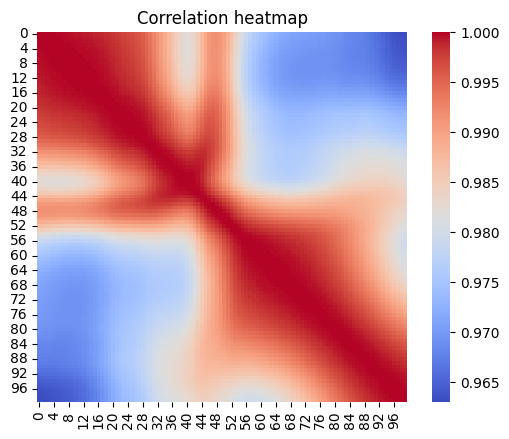

In [4]:
corr_matrix = np.corrcoef(all_results["ols_full"].X.T)
print("Maximum correlation:", corr_matrix.max())
print("Minimum correlation:", round(corr_matrix.min(), 4))

sns.heatmap(np.corrcoef(all_results["ols_full"].X.T), cmap="coolwarm", square=True)
plt.title("Correlation heatmap")
plt.show()

Note how every pair of variables has extremely high correlation. We choose to plot even those with 0.96 correlation in blue above to highlight the nontrivial structure that appears; notice that all early observations have almost perfect correlation with the middle of the domain.

Just as a point of interest, let's look at the multicollinearity of the fit. The condition number is the ratio of largest to smallest eigenvalues of $X'X$; high condition number implies that inversion of this matrix (which is exactly what we do in linear regression) can be sensitive to small changes in inputs.

In [5]:
print("Condition number of linear fit to full data:", round(all_results["ols_full"].condition_number, 2))

Condition number of linear fit to full data: 261580454030253.7


This is astronomically greater than 1000, so we have sigificant multicollinearity, as expected for functional data sampled on a fine grid.

### Leverage

What do the leverage scores for the data look like? These can be easily computed as the diagonal elements of the hat matrix $X(X'X)^{-1}X'$, and they suggest which observations may greatly influence the linear regression coefficients. Typically, we identify high leverage as greater than $\frac{2p}{n}$, where $n$ is the number of samples and $p$ is the number of predictors.

High leverage boundary: 0.93


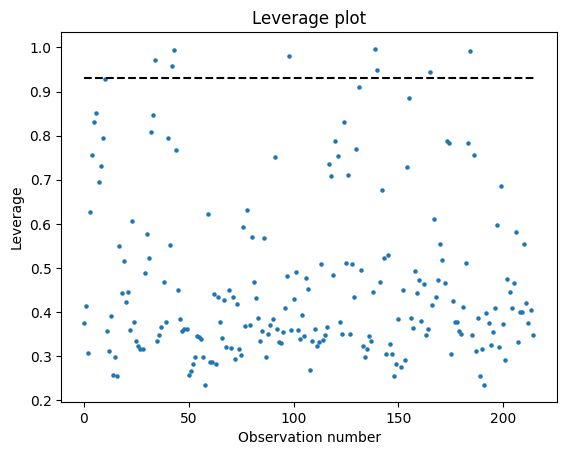

In [6]:
leverage_scores = all_results["ols_full"].leverage_scores
n, p = all_results["ols_full"].X.shape
print("High leverage boundary:", round(2*p/n, 2))

plt.scatter(list(range(len(leverage_scores))), leverage_scores, s=5)
plt.plot([0, len(leverage_scores)], [2*p/n, 2*p/n], c="black", linestyle="--")
plt.title("Leverage plot")
plt.xlabel("Observation number")
plt.ylabel("Leverage")

plt.show()

We can see that there are 7-8 high leverage samples! Leverage tells us how far a sample's regressor values are from the mean, but we also want to see how much each sample will influence a linear fit. Before moving to influential point discovery, we show plots for the linear fit to the entire data set.

### Fit plots

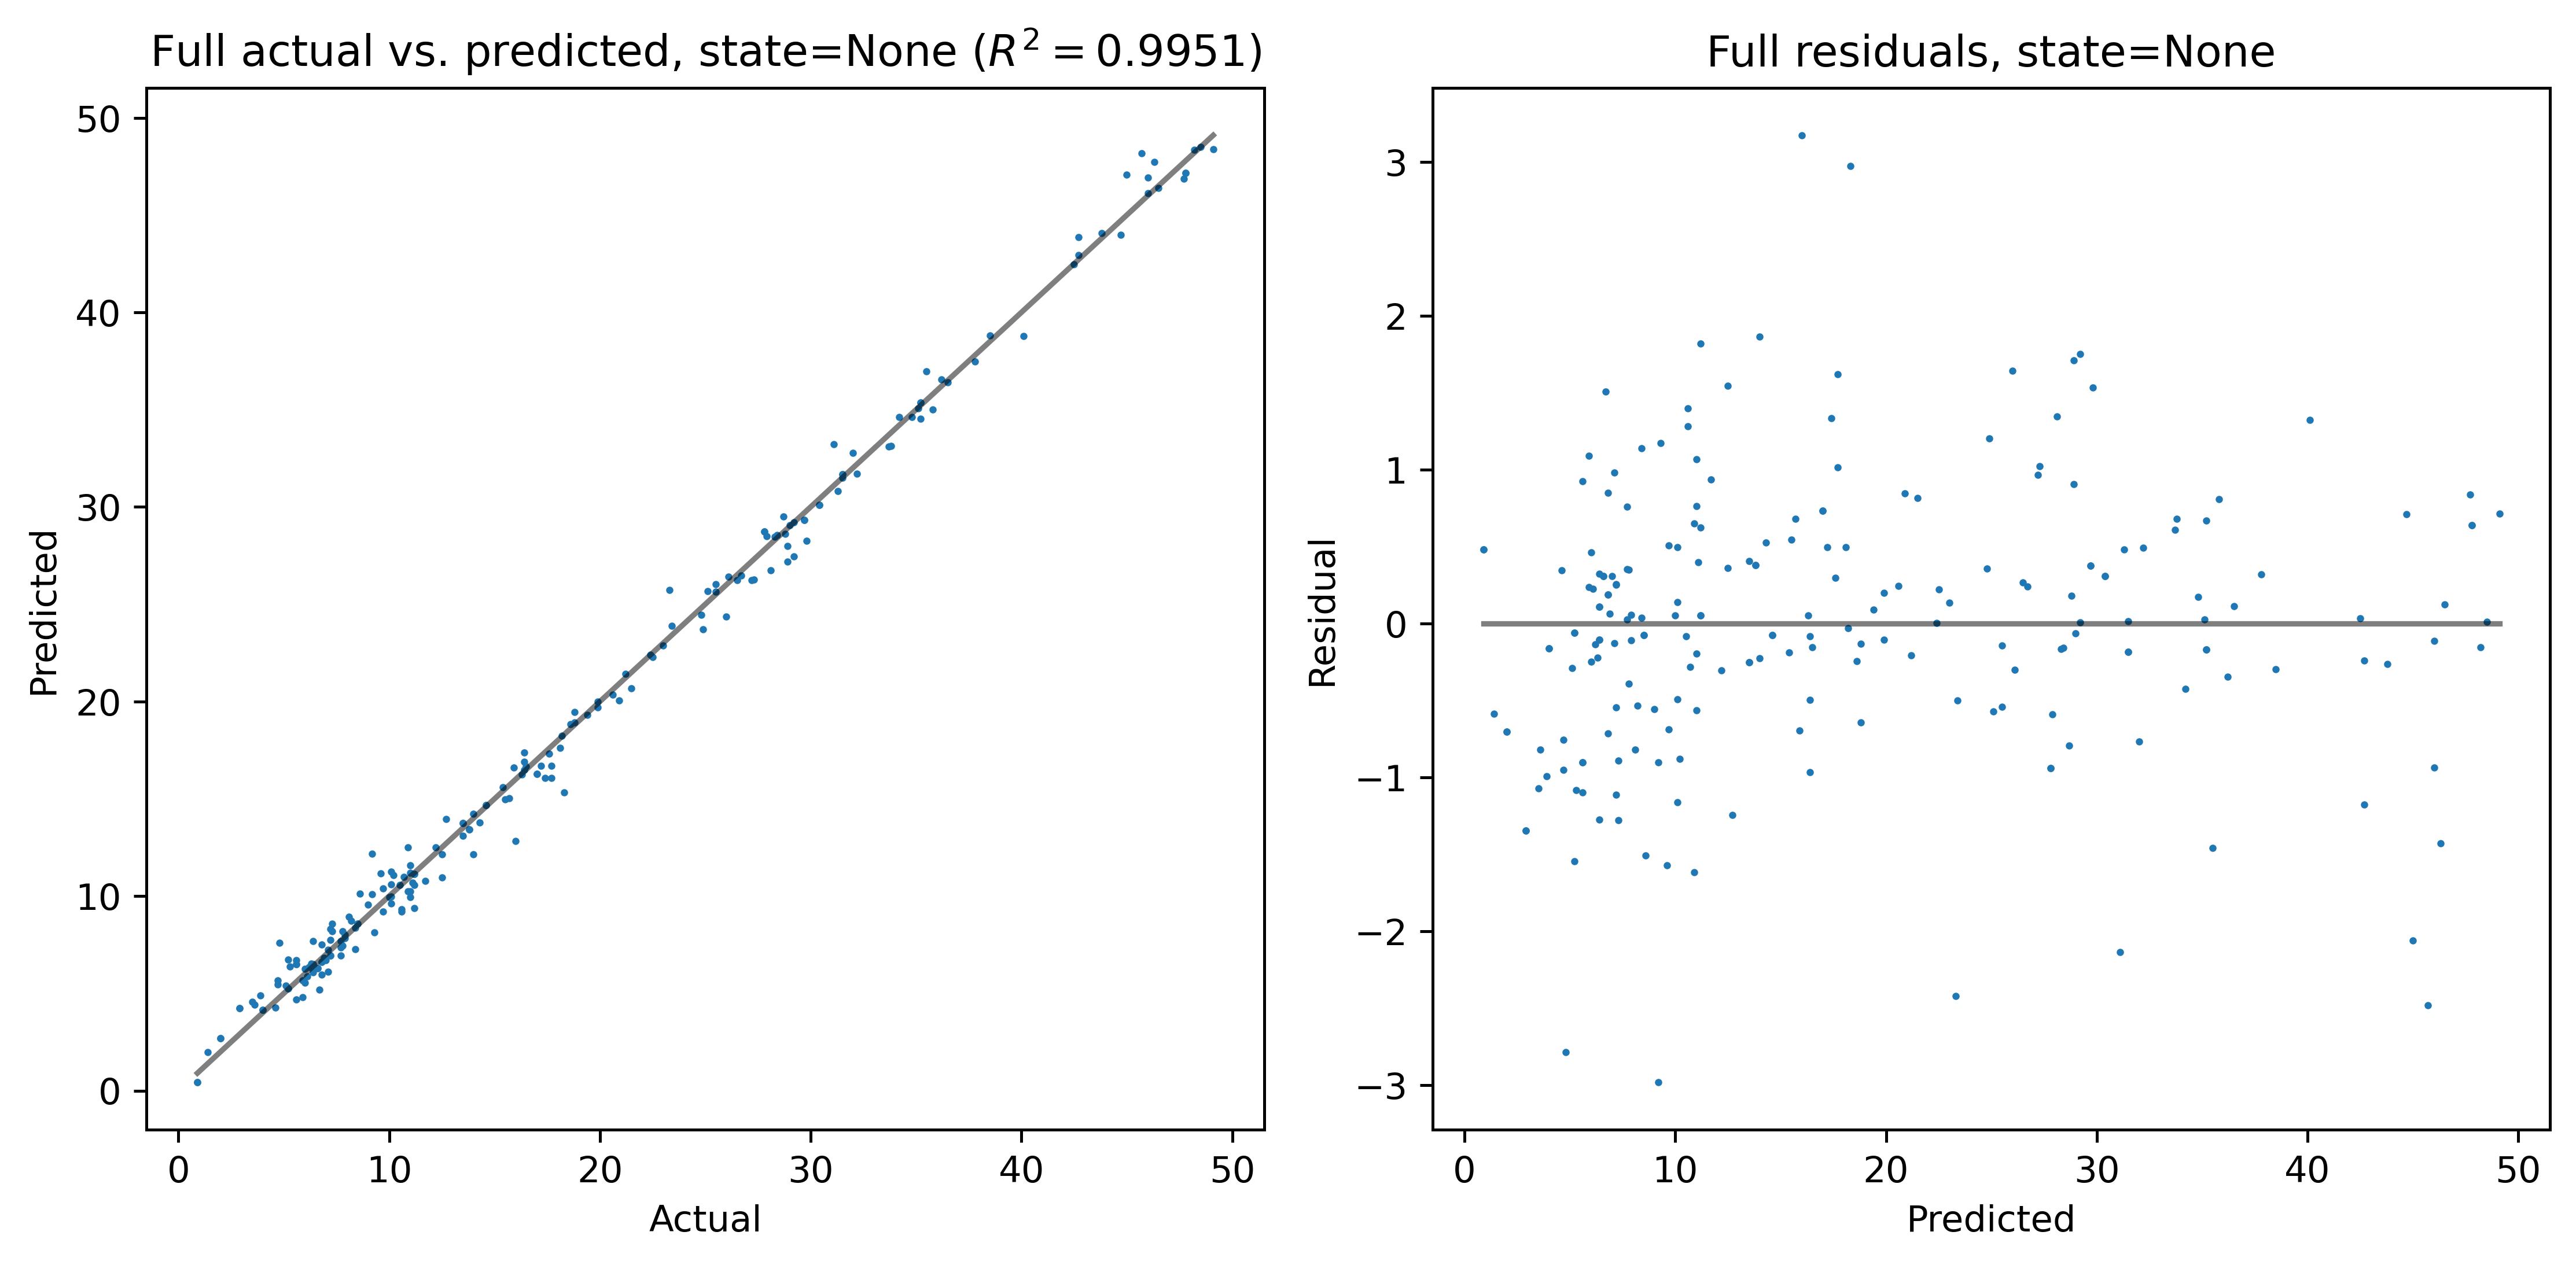

In [7]:
Image(filename="../artifacts/original_data/01_ols/plots/ols_full.png")

### Influential points (TODO)

To examine influence of each point on the linear fit, we plot leverages against the standardized residuals.

In [8]:
"""sigma2 = np.sum((all_results["ols_full"].y - all_results["ols_full"].predicted)**2) / (n-p)
standardized_residuals = (all_results["ols_full"].y - all_results["ols_full"].predicted).flatten() / np.sqrt(sigma2 * (1 - leverage_scores))

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(leverage_scores, standardized_residuals.flatten(), alpha=0.7)

ax.axhline(0, color="black", linewidth=1)
ax.axhline(2, linestyle="--", color="gray")
ax.axhline(-2, linestyle="--", color="gray")

ax.set_xlabel("Leverage")
ax.set_ylabel("Standardized Residuals")
ax.set_title("Residuals vs Leverage")

def cooks_contour(D, leverage, p):
    return np.sqrt(D * p * (1 - leverage) / leverage)

h_vals = np.linspace(leverage_scores.min() + 1e-4, leverage_scores.max(), 100)

for D in [0.5, 1]:
    r = cooks_contour(D, h_vals, p)
    ax.plot(h_vals, r, linestyle="--", color="red")
    ax.plot(h_vals, -r, linestyle="--", color="red")
    ax.text(h_vals[-1], r[-1], f"D={D}", color="red")


plt.tight_layout()
plt.show()
"""

'sigma2 = np.sum((all_results["ols_full"].y - all_results["ols_full"].predicted)**2) / (n-p)\nstandardized_residuals = (all_results["ols_full"].y - all_results["ols_full"].predicted).flatten() / np.sqrt(sigma2 * (1 - leverage_scores))\n\nfig, ax = plt.subplots(figsize=(8, 6))\n\nax.scatter(leverage_scores, standardized_residuals.flatten(), alpha=0.7)\n\nax.axhline(0, color="black", linewidth=1)\nax.axhline(2, linestyle="--", color="gray")\nax.axhline(-2, linestyle="--", color="gray")\n\nax.set_xlabel("Leverage")\nax.set_ylabel("Standardized Residuals")\nax.set_title("Residuals vs Leverage")\n\ndef cooks_contour(D, leverage, p):\n    return np.sqrt(D * p * (1 - leverage) / leverage)\n\nh_vals = np.linspace(leverage_scores.min() + 1e-4, leverage_scores.max(), 100)\n\nfor D in [0.5, 1]:\n    r = cooks_contour(D, h_vals, p)\n    ax.plot(h_vals, r, linestyle="--", color="red")\n    ax.plot(h_vals, -r, linestyle="--", color="red")\n    ax.text(h_vals[-1], r[-1], f"D={D}", color="red")\n\n\np

There doesn't seem to be a clear pattern in the residuals, which suggests the linear model captures the behavior of the data. However, due to the significant multicollinearity and presence of influential points, we have reason to attempt our other methods. However, let's examine OLS regression on a holdout set, first.

## Holdout set diagnostics

### Fit plots

First, let's use `random_state = 0`. Like above, we examine actual vs. predicted and residual plots.

Train:

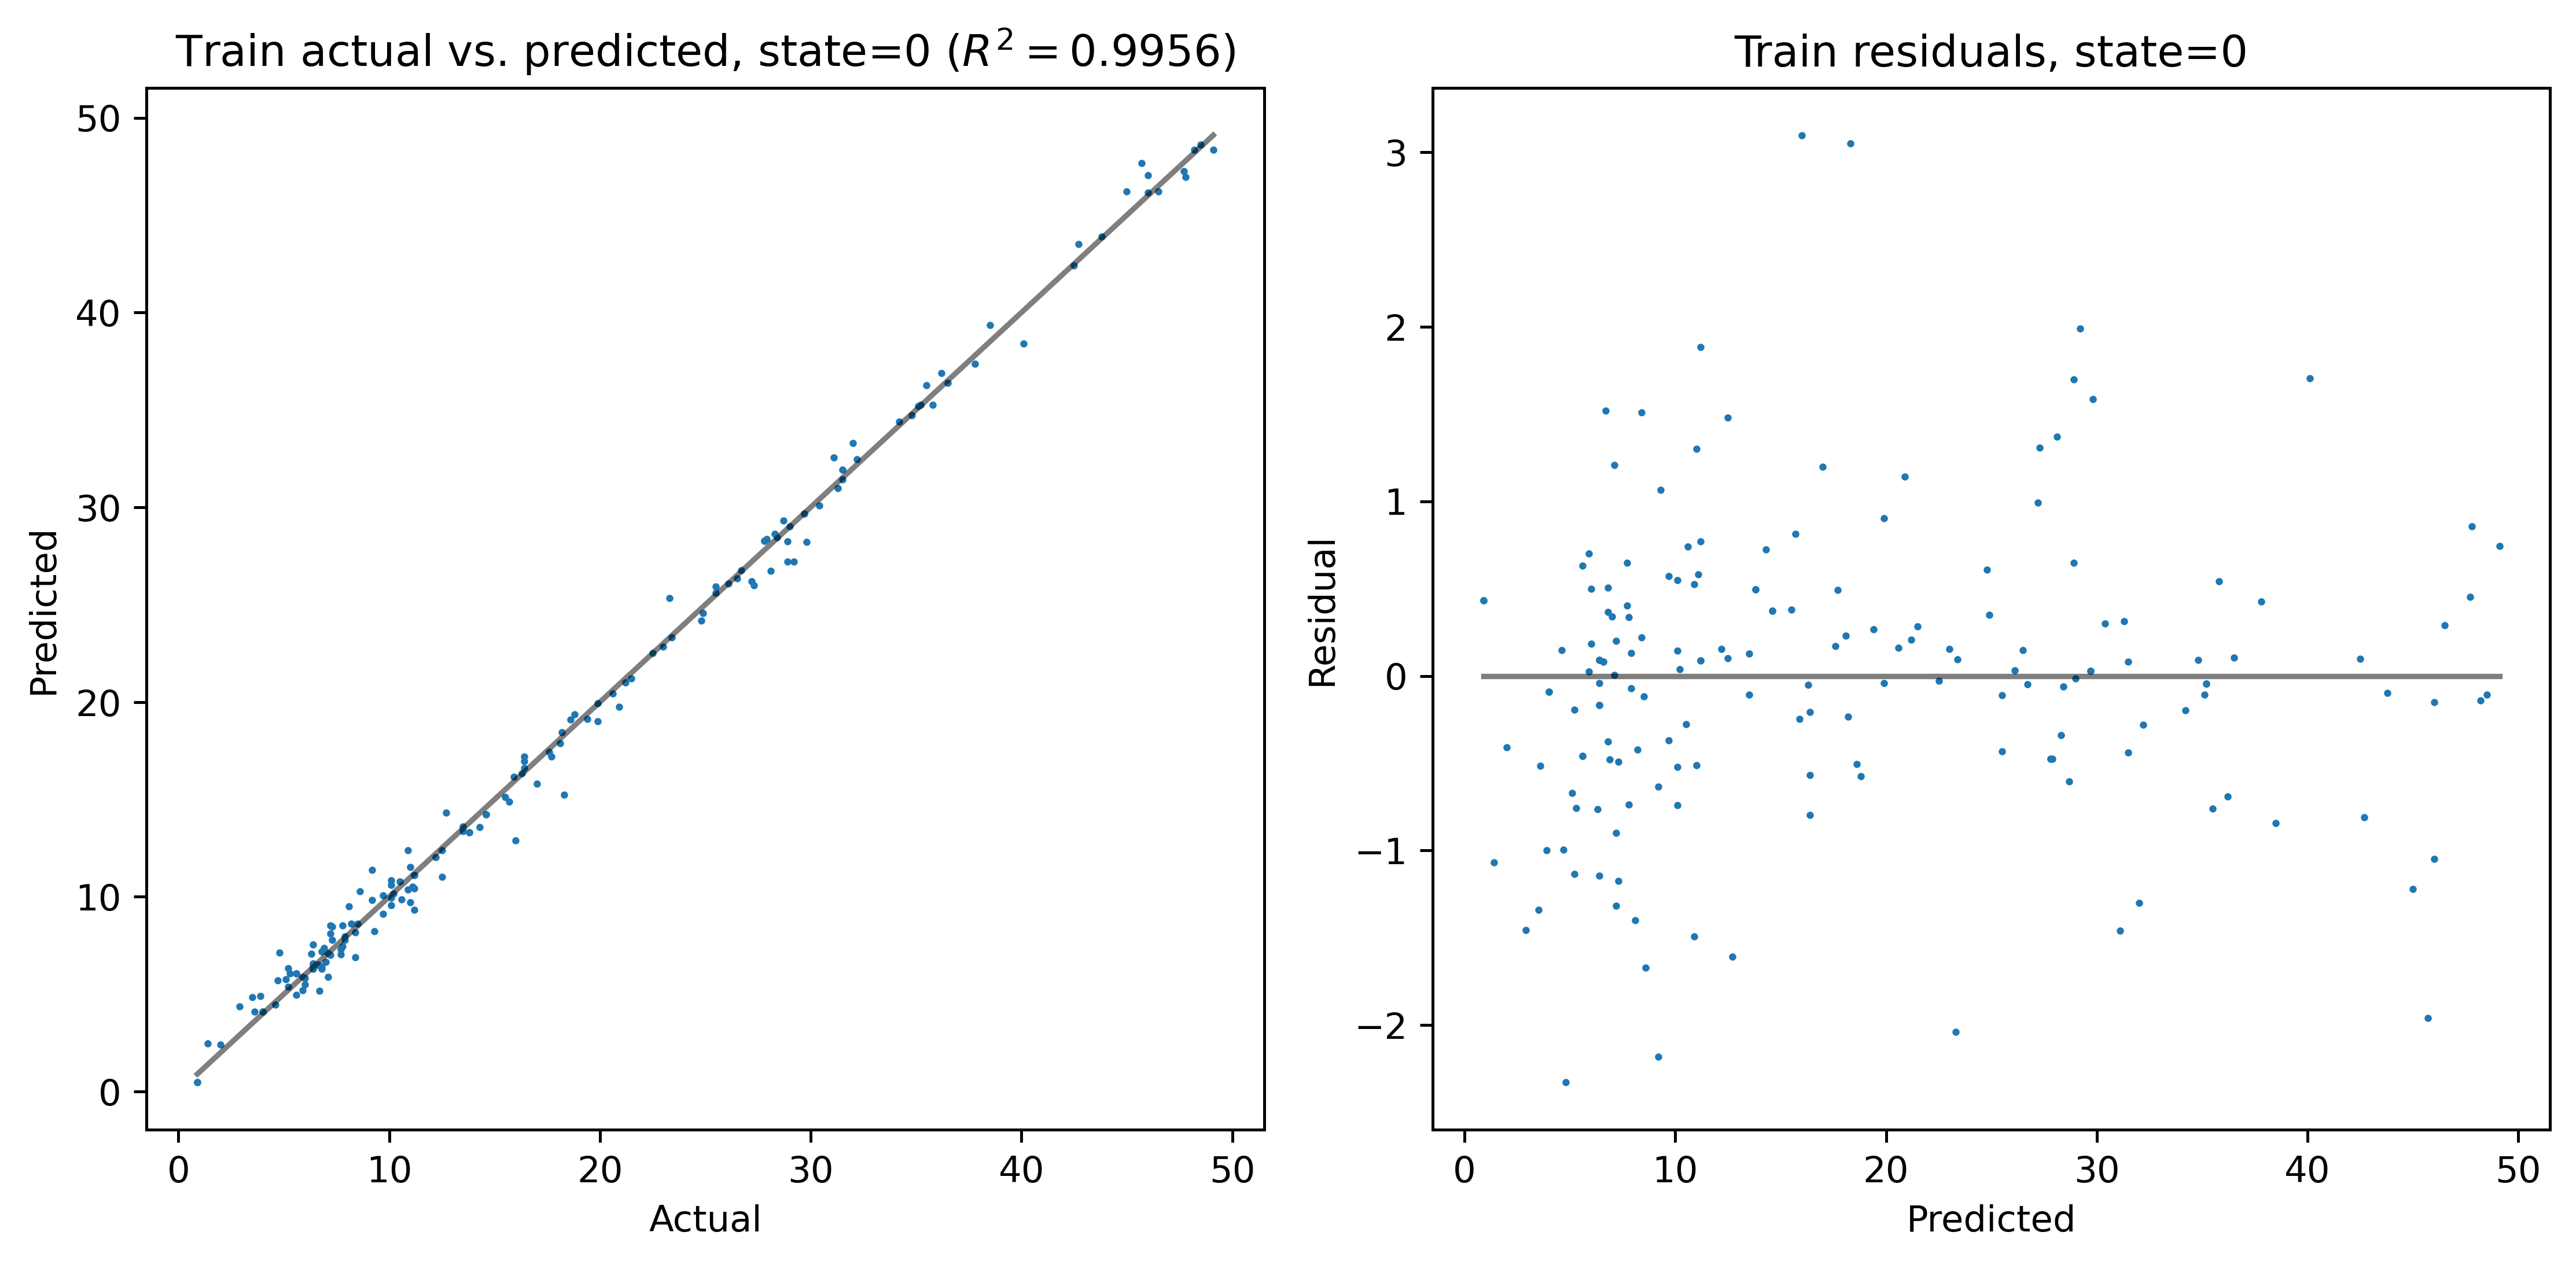

In [9]:
Image(filename="../artifacts/original_data/01_ols/plots/ols_0_train.png")

Test:

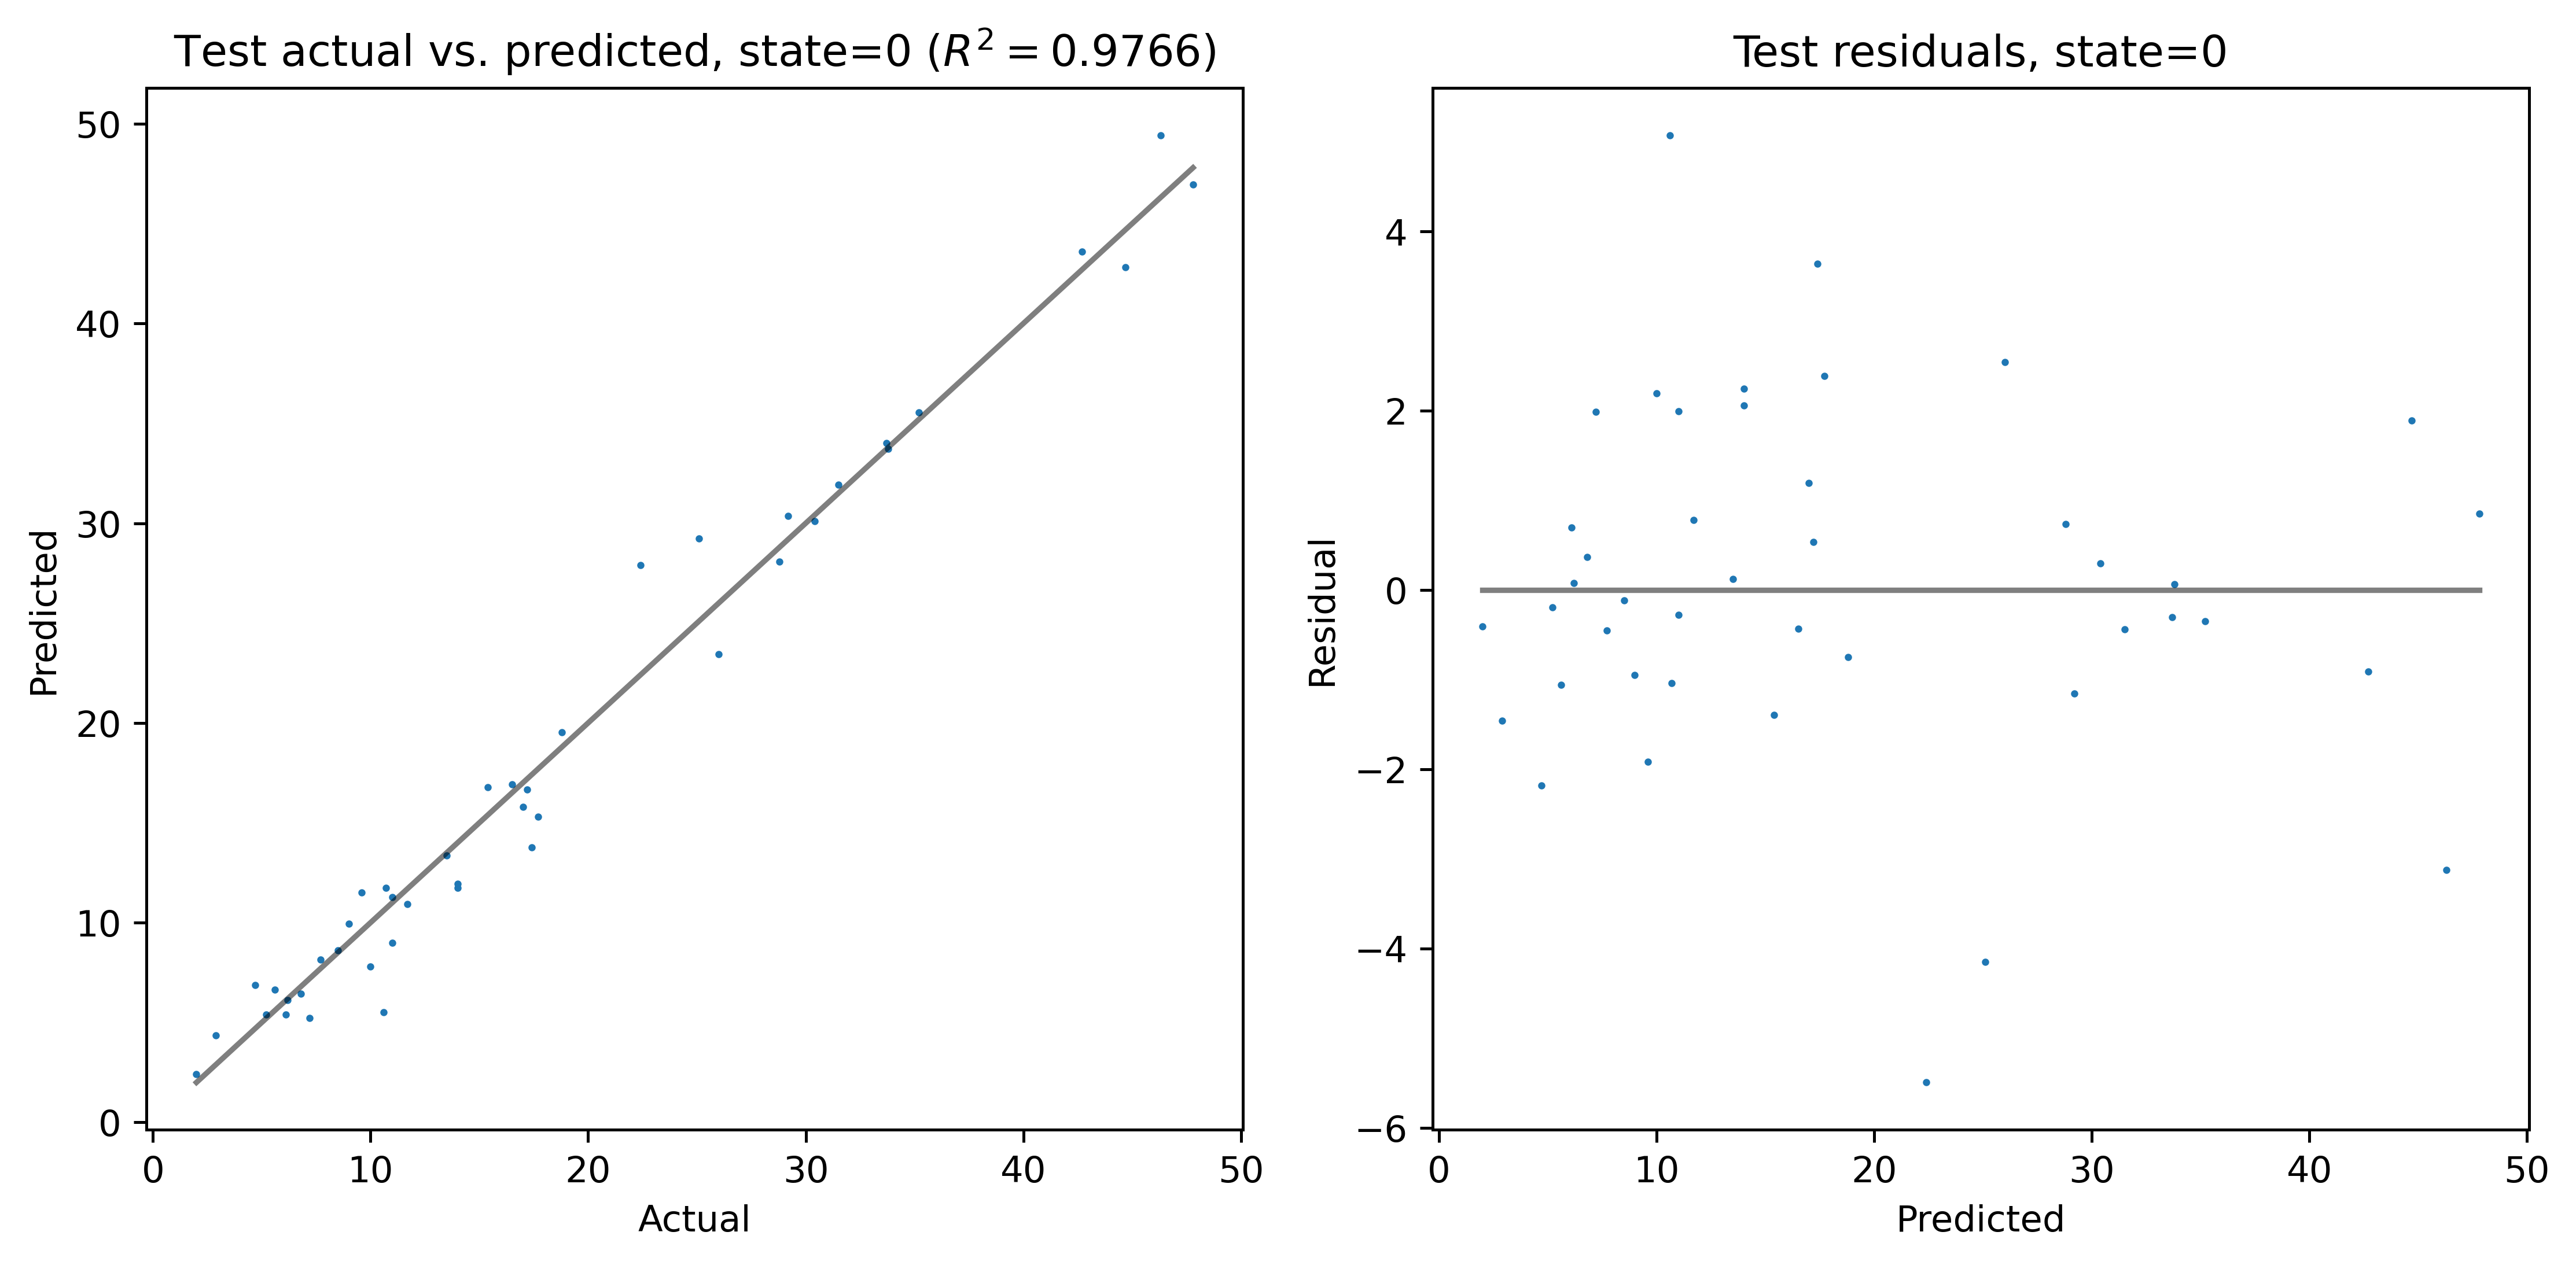

In [10]:
Image(filename="../artifacts/original_data/01_ols/plots/ols_0_test.png")

This looks good! Let's use `random_state = 42` now.

Train:

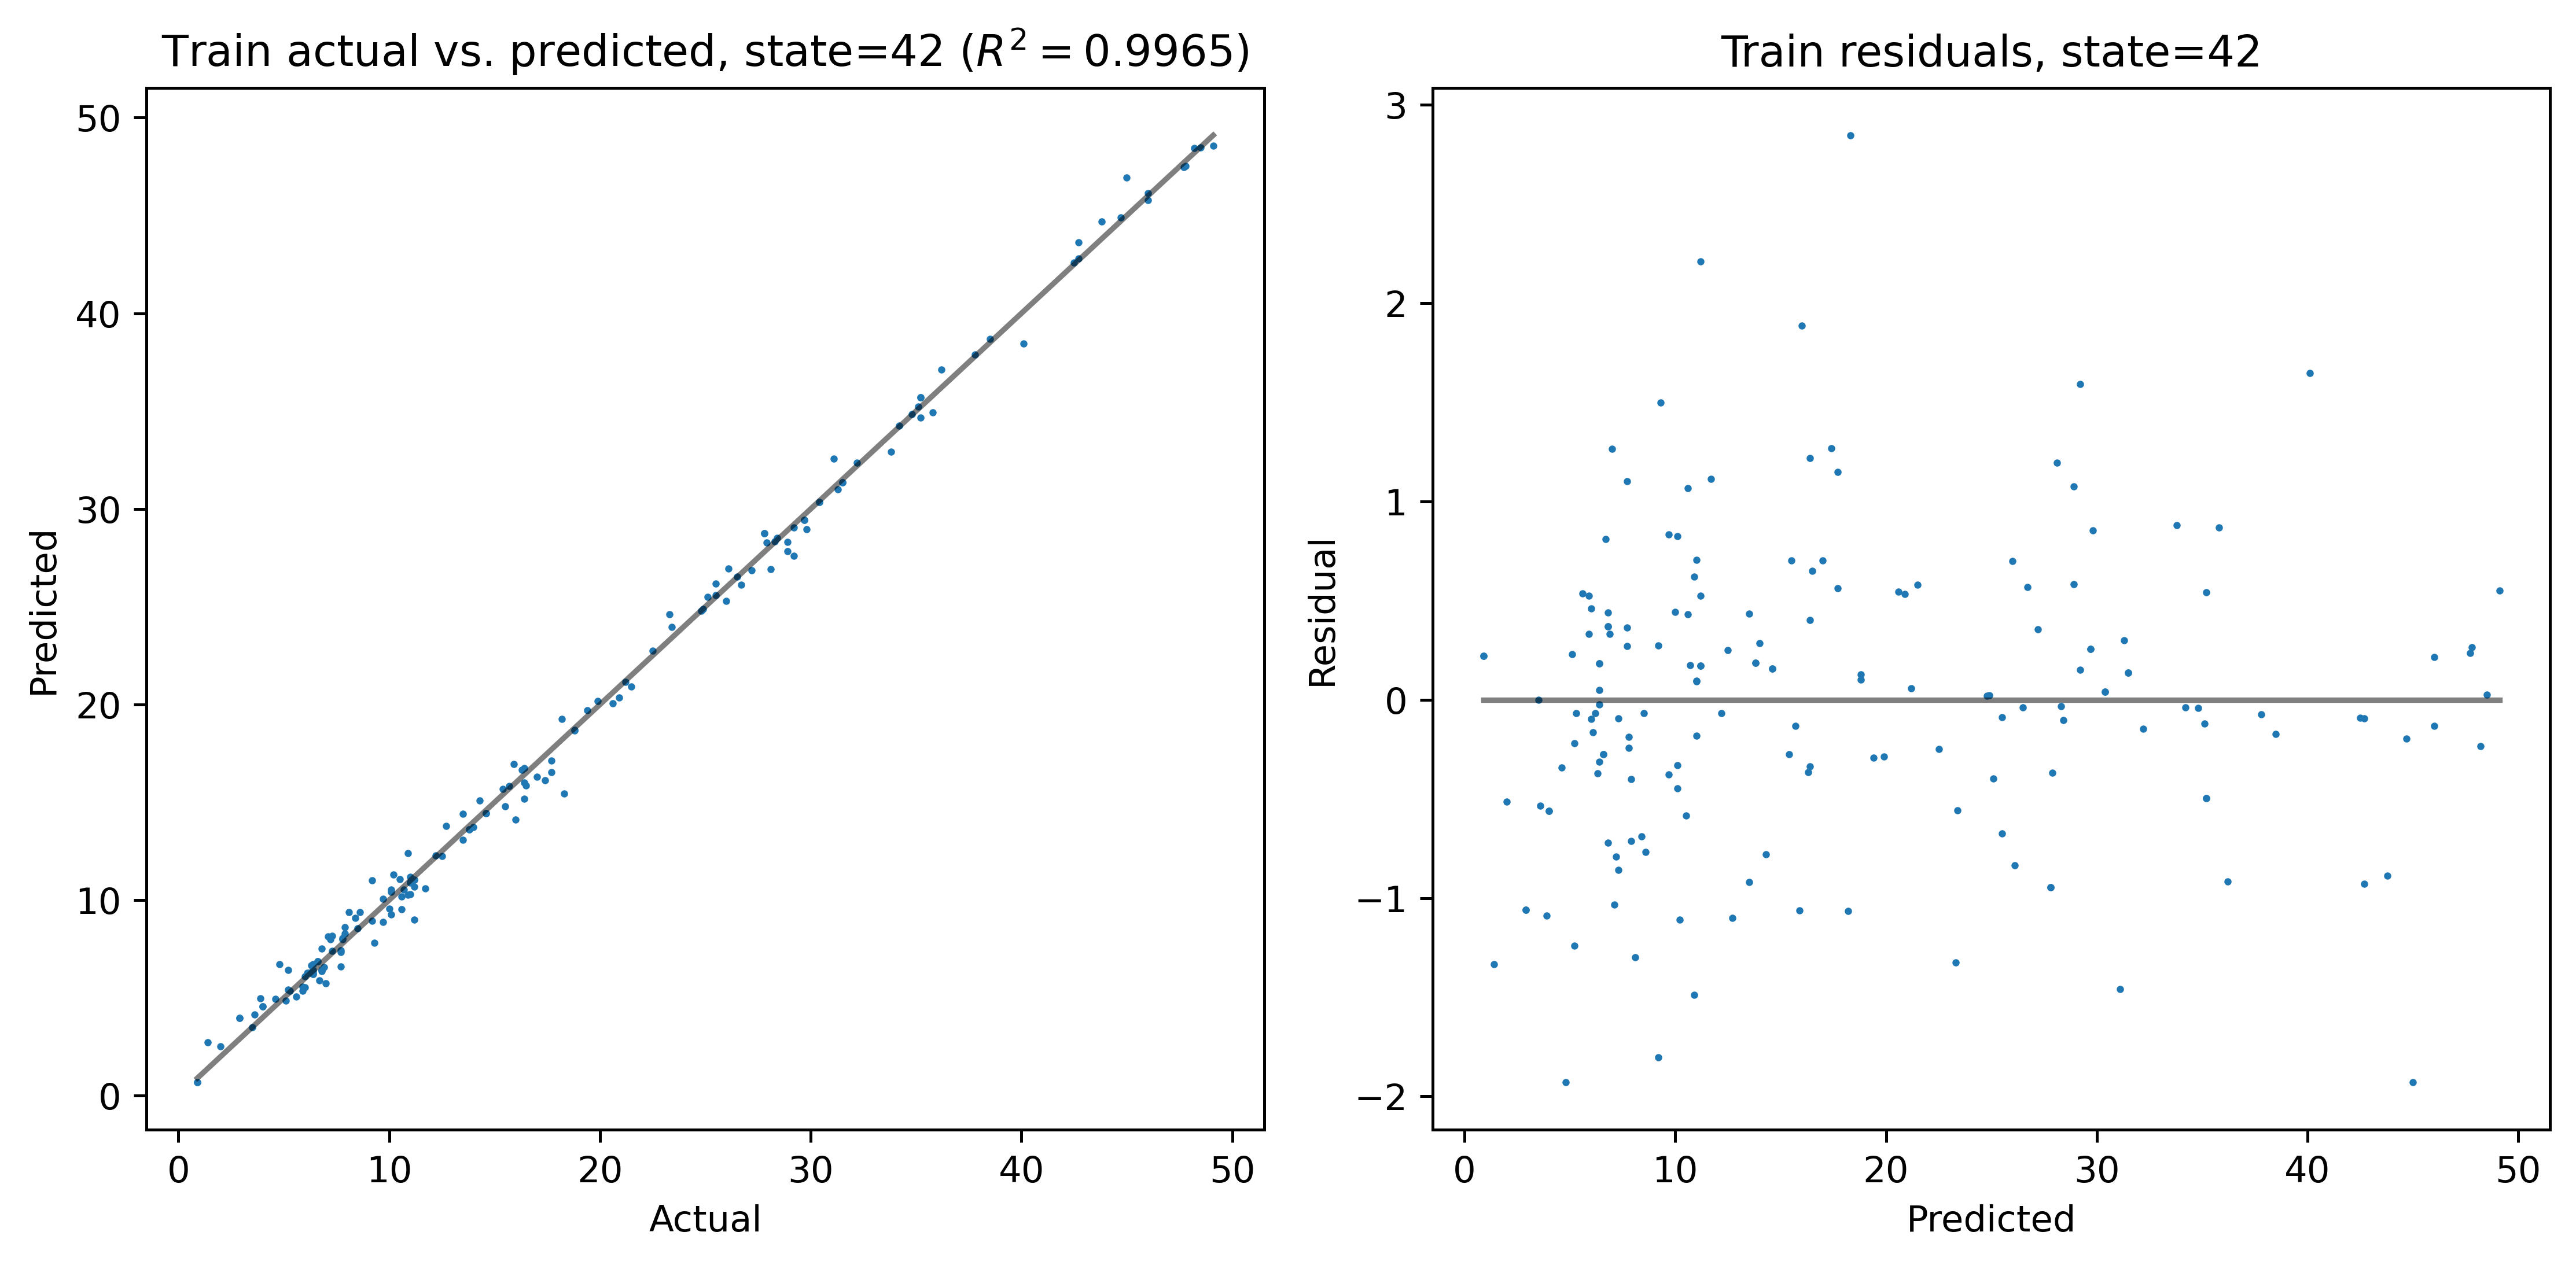

In [11]:
Image(filename="../artifacts/original_data/01_ols/plots/ols_42_train.png")

Test:

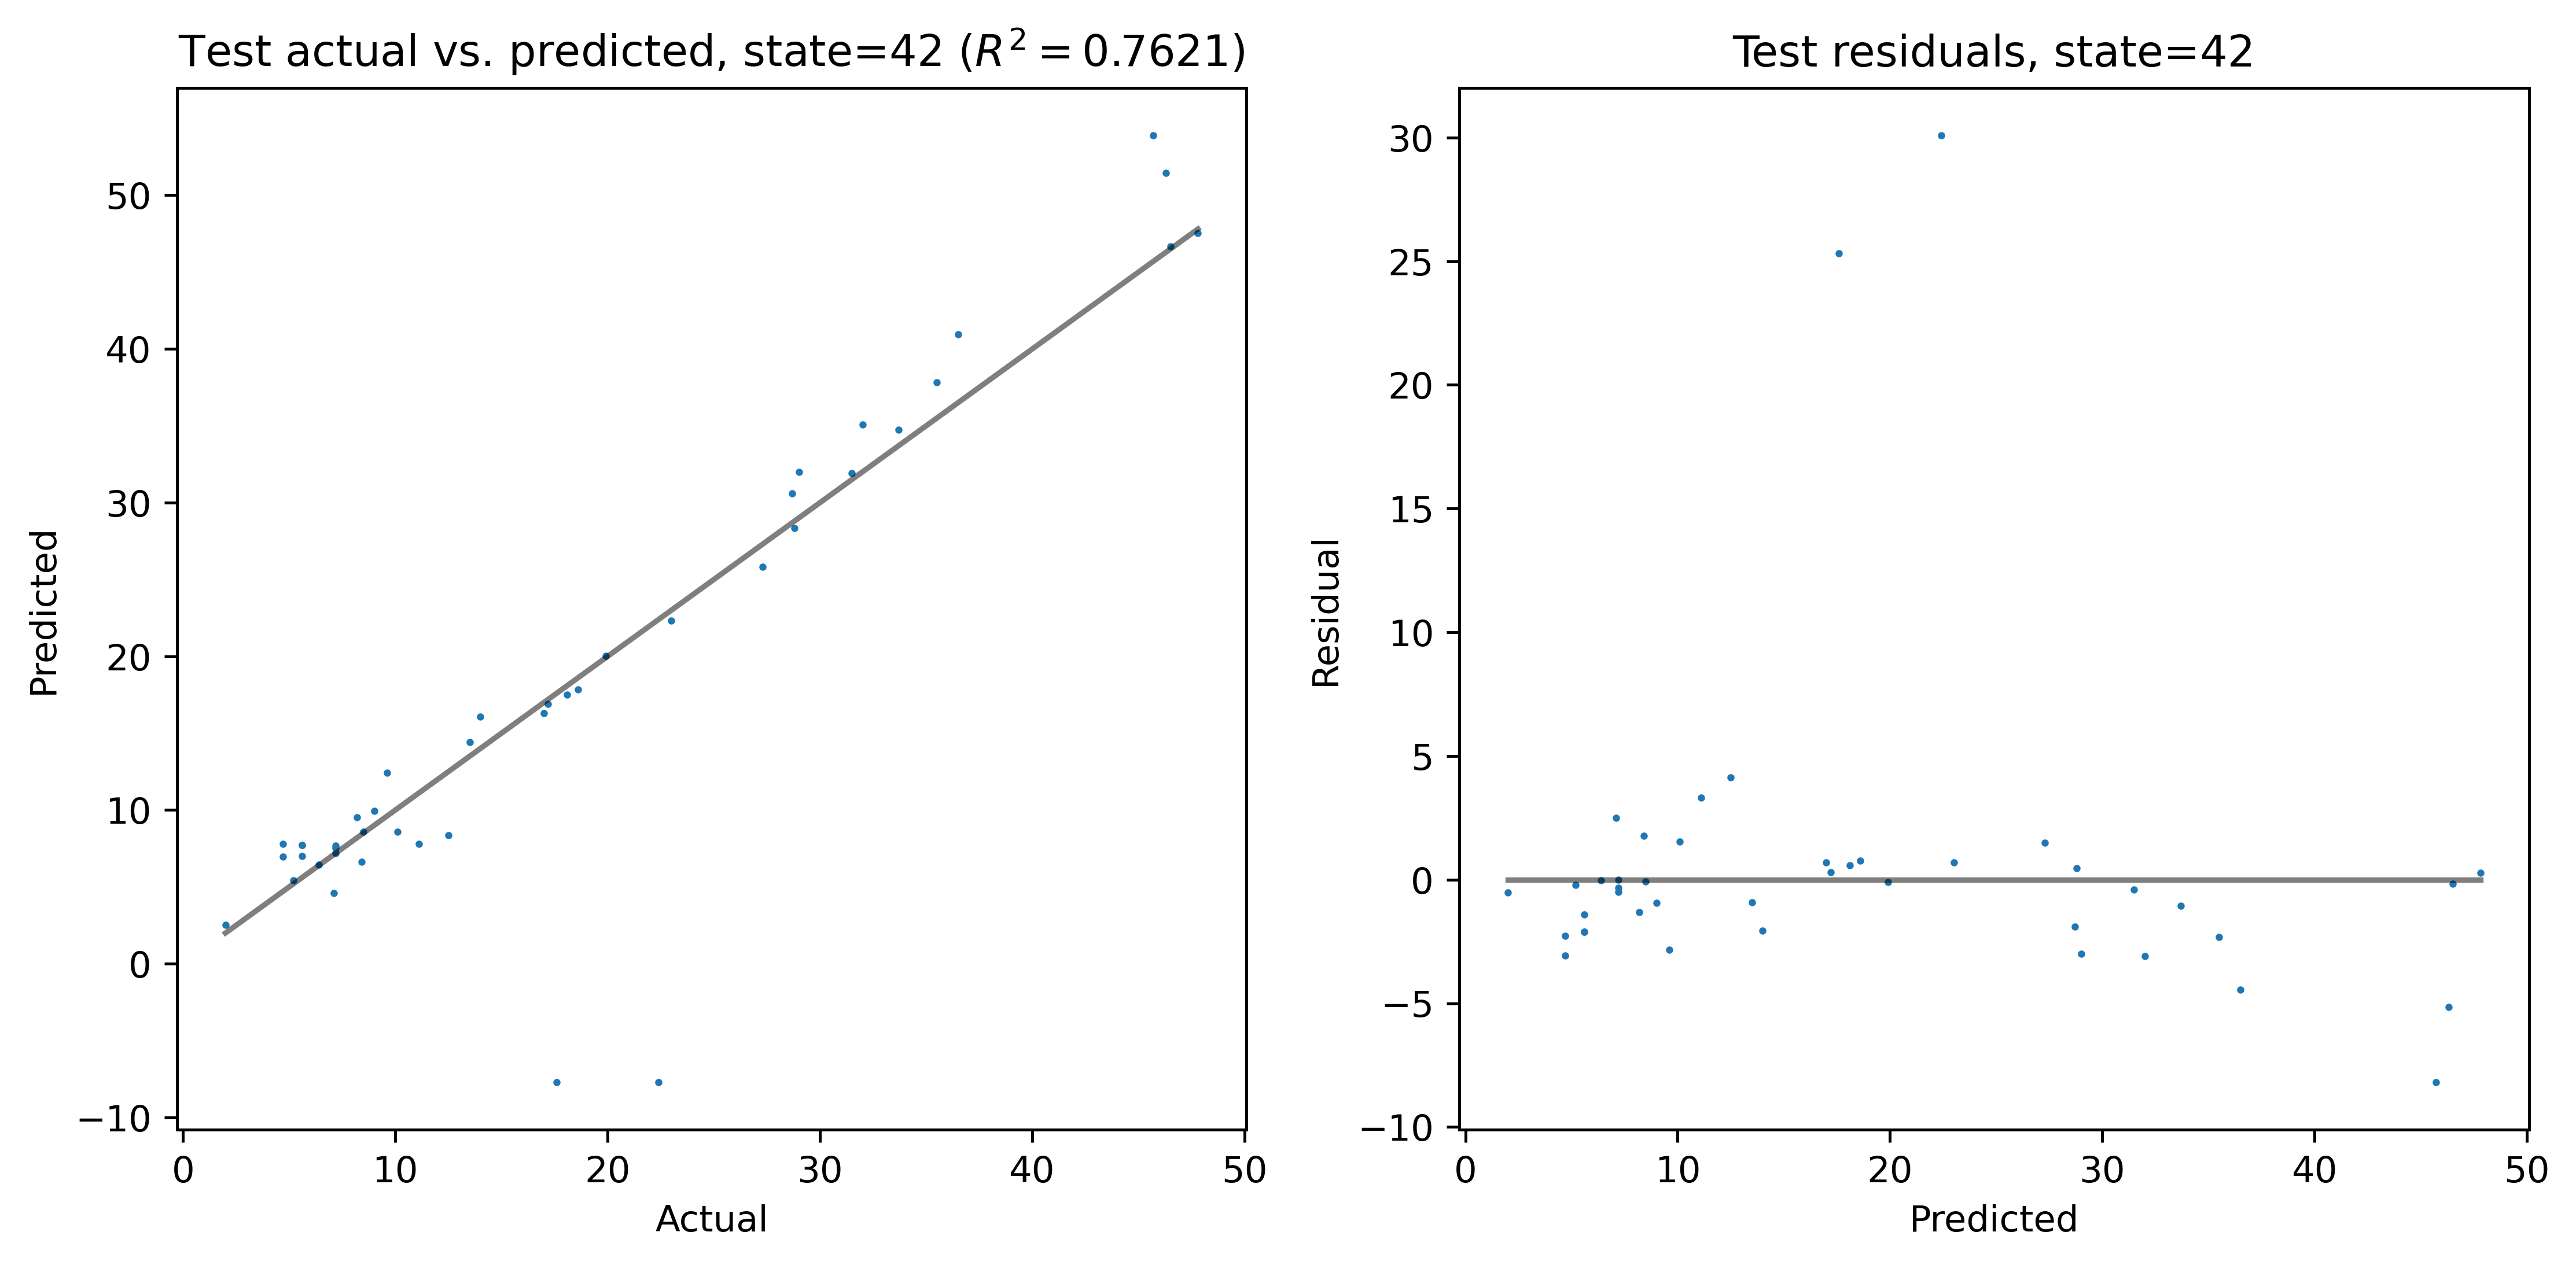

In [12]:
Image(filename="../artifacts/original_data/01_ols/plots/ols_42_test.png")

Test $R^{2}$ is lower for this split, with some strong outliers. Let's look at them all together.

### $R^{2}$ values

We examine $R^{2}$ values for each of the three fits.

In [13]:
print("R^2 for full data:", round(all_results["ols_full"].r2_score, 4))
print()
print("Train R^2 for random state 0:", round(all_results["ols_0_train"].r2_score, 4))
print("Test R^2 for random state 0: ", round(all_results["ols_0_test"].r2_score, 4))
print()
print("Train R^2 for random state 42:", round(all_results["ols_42_train"].r2_score, 4))
print("Test R^2 for random state 42: ", round(all_results["ols_42_test"].r2_score, 4))

R^2 for full data: 0.9951

Train R^2 for random state 0: 0.9956
Test R^2 for random state 0:  0.9766

Train R^2 for random state 42: 0.9965
Test R^2 for random state 42:  0.7621


Interesting! We see that two random states have drastically different test $R^{2}$ values. Because of this, we choose to move to cross-validation to truly diagnose linear regression's capabilities for these data.

Popular choices for cross-validation are 5-fold and 10-fold; we choose 10-fold here because computations aren't expensive for this project and 10 gives us less bias in our error estimates. We also use repeated 10-fold cross-validation to get a better sense for the fits.

## Repeated 10-fold cross-validation

R^2 mean: 0.9308
R^2 standard deviation: 0.0773


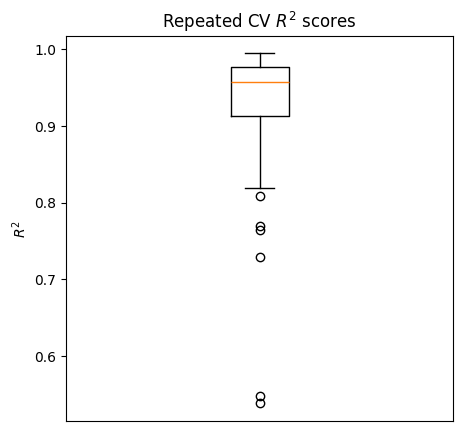

In [14]:
print("R^2 mean:", round(all_results["ols_cv"].r2_mean, 4))
print("R^2 standard deviation:", round(all_results["ols_cv"].r2_std, 4))

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.boxplot(all_results["ols_cv"].r2_scores)
ax.set_title("Repeated CV $R^{2}$ scores")
ax.set_xticks([])
ax.set_ylabel("$R^{2}$")
plt.show()

This gives us a much more accurate picture. Note the continued presence of lower outliers; these are probably runs where our influential functionals lie in the holdout set.

Now that we have deeply analyzed the discrete linear fit to the data, we are ready to move on to a ridge regression analysis in the notebook `02_ridge.ipynb`.